# **Model Fishera** #

# Spis Treści #
- Część Opisowa - przedstawienie charakterystyki oraz założeń modelu
- Część Modelowa - kod z implementacją modelu
- Część Graficzna - wizualizacja modelu, przygotowanie wyników symulacji do analizy
- Część Analityczna - dyskusja wyników
- Część Ewaluacyjna - komentarz, co poszło dobrze, co źle, co można by było poprawić

# Część Opisowa #

*Osobnik*:
- Osobniki są diploidalne i rozmnażają się płciowo
- Posiadają Genotyp - zestaw genów
- $n > 2$, ilość cech/genów osobnika
- Reprezentacja genu - $[0,1]$ w dwóch kopiach na osobnika, w niezdefiniowanych arbitralnych jednostkach
- Fenotyp - uzewnętrznienie genów danego osobnika (to co Środowisko będzie "widziało" i po czym będzie selekcjonować)
- Reprezentacja fenotypu kodowanego przez dany gen - $o \in [0,1]$
- Genotyp wpływa na Fenotyp (przez zdefiniowaną funkcję, tu: średnia arytmetyczna: $gen \in\mathbb{R}^{n\times 2}$ $\rightarrow fen \in\mathbb{R}^{n}$, tutaj 2 oznacza diploidalność)

*Populacja*:
- $N_0$, początkowa wielkość populacji
- $\mu$, prawdopodobieństwo zajścia mutacji, tu: dla uproszczenia mutacje obejmują od razu cały genom, a nie pojedynczy gen
- $\sigma$, efekt mutacji, odchylenie standardowe jednego zdarzenia mutacji, $mutacja \sim \mathcal{N}(0, \sigma)$

*Środowisko*:
- Środowisko posiada Optymalny Fenotyp, $\alpha\in\mathbb{R}^n$, tj. zestaw cech, które Środowisko "oczekuje" w Osobniku by je uwidocznił jeśli dany Osobnik ma zamiar się rozmnażać
- Funkcja oceny fenotypu (adaptacji/przystosowania/dostosowania/fitness) osobnika będzie obliczana jako odległość wektora Optymalnego Fenotypu od Fenotypu osobnika. Ta wartość jest następnie przekształcana, tak żeby była w zakresie $[0,1]$, gdzie: 0 - brak adaptacji, 1 - idealna adaptacja. Funkcja $\phi = exp(-||\alpha - o||_2)$ gwarantuje taki zakres wartości.

*Rozmnażanie*:
- Rozmnażanie odbywa się poprzez "przejście" przez populację żeńską, losowym wyborem osobnika z populacji męskiej, losowym wyborem płci potomka, losowym wyborem jedengo z zestawów genów z obu rodziców i nieznacznym zaburzeniem go, $lekkieZaburzenieGenuPotomka \sim \mathcal{N}(0, \delta)$, $\delta = 10^{-4}$
- Liczba potomstwa na rodziców podlega rozkładowi Poissona, $liczbaPotomków \sim \mathrm{Poisson}(2.1 \times \frac{(N_0 - N)}{N_0})$, gdzie $N_0$, jest traktowane jak pojemność środowiska. Dla uproszczenia w kodzie zamiast całej populacji brana jest pod uwagę tylko populacja żeńska, a współczynnik dzietności (ang. _replacement-level fertility_) 2.1 jest mnożony razy 2.
- W symulacji zachodzi tylko jedna "sesja" rozmnażania na pokolenie

*Dodatkowe założenia symulacji*:
- Jedno pokolenie przechodzi przez kroki w kolejności: mutacja $\rightarrow$ selekcja $\rightarrow$ reprodukcja
- Cała stara populacja jest zastępowana nową - każdy osobnik umiera po jednym pokoleniu

*Cele projektu*:
- Zilustrowanie procesu dynamiki liczby populacji, różnorodności genetycznej populacji oraz procesu selekcji naturalnej
- Zbadanie wpływu częstości oraz efektu mutacji przyżywalność oraz różnorodność genetyczną populacji
- Wpływ zmian klimatycznych i katastrof na dynamikę liczby populacji oraz różnorodności genetycznej populacji

# Część Modelowa #

In [1]:
import pandas as pd
import numpy as np
import math
import random
from copy import deepcopy
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import imageio
import warnings; warnings.simplefilter('ignore')

In [3]:
class Specimen:
    def __init__(self, s: int, traits1: np.ndarray, traits2: np.ndarray) -> None:
        self.s = s # płeć (0, 1) = (male, female)
        self.traits1 = traits1 # 1. zestaw genów
        self.traits2 = traits2
        # fenotyp i adaptacja
        self.phenotype = np.zeros(len(self.traits1))
        self.adaptation = 0
        self.calc_phenotype()
        self.calc_adaptation(np.zeros(len(self.traits1))) # pocz. optimum zawsze zerowym wektorem

    def mutate_genes(self, sigma: float):
        """Funkcja mutująca zestawy genów"""
        self.traits1 += np.random.normal(0, sigma, len(self.traits1))
        self.traits2 += np.random.normal(0, sigma, len(self.traits2))
        # założenie że mu dotyczy wszystkich genów

    def calc_phenotype(self):
        """Funkcja obliczająca fenotyp osobnika na podstawie genotypu"""
        # Może być max lub min jako dominacja któregoś allelu
        # Tu: średnia arytmetyczna
        self.phenotype = (self.traits1 + self.traits2) / 2

    def calc_adaptation(self, optimum: np.ndarray):
        """Funkcja licząca przystosowanie osobnika jako odległość jego fenotypu od optimum"""
        self.adaptation = math.exp(-np.linalg.norm(optimum - self.phenotype))

class Population:
    def __init__(self, N: int, n: int) -> None:
        self.N = N # liczba populacji
        self.malePop = [Specimen(0, self.rand_traits(n), self.rand_traits(n)) for _ in range(N // 2)] # męska populacja
        self.femalePop = [Specimen(1, self.rand_traits(n), self.rand_traits(n)) for _ in range(N - N//2)] # żeńska populacja

    def rand_traits(self, n: int) -> np.array:
        """Funkcja generuje losowy zestaw cech dla nowego osobnika"""
        omicron = 0.2 # wariancja cech nowych osobników
        # czyli średnia adaptacja (początkowa) w populacji będzie ok. 1.0-2*sigma
        # return np.random.rand(n) * 1 # "wartości" genu z uniform(0,1)
        # return np.zeros(n) # wszyscy zaczynają optymalnie
        return np.random.normal(0, omicron, n) # "wartości" genu z normal(0,1)

class Environment:
    def __init__(self, N0: int, n: int, mu: float, sigma: float, option=None) -> None:
        self.optimum = np.zeros(n) # optymalny fenotyp
        self.population = Population(N0, n) # N0 - liczebność początkowa
        self.mu = mu # prawd. mutacji
        self.sigma = sigma # wariancja mutacji
        self.n = n # liczba genów na osobnika
        self.step = 0
        self.event = None
        if not option:
            self.option = "no_change"
        else:
            self.option = option # opcje: no_change, climate_change albo catastrophe
        self.N0 = N0

        # inicjalizacja rekordów
        cols = ["step", "N", "adaptations", "phenotypes", "optimum", "event"]
        # step(=czas), N(=licz.pop), adaptacje(shape=N), fenotypy(shape=Nxn), optimum(shape=n), event
        adaptations = []
        phenotypes = []
        for specimen in self.population.femalePop:
            adaptations.append(specimen.adaptation)
            phenotypes.append(specimen.phenotype)
        for specimen in self.population.malePop:
            adaptations.append(specimen.adaptation)
            phenotypes.append(specimen.phenotype)
            
        self.history = pd.DataFrame([[self.step,
                                      N0,
                                      deepcopy(adaptations),
                                      deepcopy(phenotypes),
                                      deepcopy(list(self.optimum)),
                                      self.event]], columns=cols)
        self.step += 1

    def change_optimum(self):
        """Funkcja zmieniająca optymalną wartość fenotypu"""
        if self.option == "no_change": return
        elif self.option == "climate_change":
            climate_change_effect = self.mu*10 #
            self.optimum += climate_change_effect*np.random.normal(0, 1, self.n)
        elif self.option == "catastrophe":
            self.catastrophe()
     
    def catastrophe(self):
        """Funkcja zmieniająca optimum poprzez duże losowe zmiany co 1/T pokoleń"""
        # Wybierz losowy zestaw "M" cech, które radykalnie zmienią optymalną wartość
        # co T pokoleń, tzn. z prawdopodobieństwem 1/T
        M = 5 # < n
        T = 150 #
        if random.random() < 1/T:
            indices = random.sample(range(0, self.n), M)
            options = ["Meteorite", "Nuclear War", "Pandemic", "Godzilla", "Global Drought", "Armageddon"] # czemu nie
            catastrophe_effect = self.mu*200 #
            change = np.array([catastrophe_effect*random.uniform(1, self.n) if i in indices else 0 for i in range(self.n)])
            self.optimum += change
            self.event = random.choice(options)

    def mutate_and_update(self, specimen: Specimen):
        """Funkcja pomocnicza mutująca pojedynczy wektor genów i aktualizująca fenotyp i adaptację"""
        if random.random() < self.mu:
            specimen.mutate_genes(self.sigma) # mutacja genów
            specimen.calc_phenotype() # zmiana fenotypu
            specimen.calc_adaptation(self.optimum) # zmiana adaptacji

    # Funkcje modyfikujące populację
    def all_mutation(self):
        """Funkcja przeprowadzająca mutacje osobników w populacji"""
        mutation = np.vectorize(self.mutate_and_update, otypes=[Specimen])
        mutation(self.population.malePop)
        mutation(self.population.femalePop)

    def all_selection(self):
        """Funkcja dokonująca selekcji osobników w populacji na podstawie dostosowania"""
        selMalePop = []
        for specimen in self.population.malePop:
            if random.random() < specimen.adaptation:
                selMalePop.append(specimen)
        selFemalePop = []
        for specimen in self.population.femalePop:
            if random.random() < specimen.adaptation:
                selFemalePop.append(specimen)
        self.population.malePop = deepcopy(selMalePop)
        self.population.femalePop = deepcopy(selFemalePop)
        # print(f"{len(self.population.malePop) + len(self.population.femalePop)} went thru selection")

    def all_reproduction(self):
        """Funkcja przeprowadzająca proces rozmnażania populacji"""
        newMales = []
        newFemales = []
        delta = 1e-4
        for mommy in self.population.femalePop:
            if len(self.population.malePop):
                males = len(self.population.malePop)
            else:
                return
            daddy = self.population.malePop[random.randrange(males)]

            offsprings = np.random.poisson(4.2/((self.N0/(self.N0 - len(self.population.femalePop)))))
            # liczba potomków

            for baby in range(offsprings):
                if random.random() < 0.5: # płeć
                    s = 0 # male
                else:
                    s = 1 # female

                if random.random() < 0.5: # 1. zestaw genów
                    traits1 = deepcopy(mommy.traits1 + random.gauss(0, delta))
                else:
                    traits1 = deepcopy(mommy.traits2 + random.gauss(0, delta))
                
                if random.random() < 0.5: # 2. zestaw genów
                    traits2 = deepcopy(daddy.traits1 + random.gauss(0, delta))
                else:
                    traits2 = deepcopy(daddy.traits2 + random.gauss(0, delta))
                baby = Specimen(s, traits1, traits2)
                baby.calc_phenotype()
                baby.calc_adaptation(self.optimum)
                if s == 0:
                    newMales.append(baby)
                else:
                    newFemales.append(baby)

        self.population.malePop = deepcopy(newMales)
        self.population.femalePop = deepcopy(newFemales)

    def record_history(self, step: int):
        """Funkcja aktualizująca rekordy"""
        assert self.step == step, f"Numer kroku w rekordach nie zgadza się z tym w symulacji: {self.step} i {step}"

        adaptations = []
        phenotypes = []
        for specimen in self.population.femalePop:
            adaptations.append(specimen.adaptation)
            phenotypes.append(specimen.phenotype)
        for specimen in self.population.malePop:
            adaptations.append(specimen.adaptation)
            phenotypes.append(specimen.phenotype)
        
        cols = ["step", "N", "adaptations", "phenotypes", "optimum", "event"]
        new_record = pd.DataFrame([[self.step,
                                    len(self.population.malePop) + len(self.population.femalePop),
                                    deepcopy(adaptations),
                                    deepcopy(phenotypes),
                                    deepcopy(list(self.optimum)),
                                    self.event]], columns=cols)
        # step(=czas), N(=licz.pop), adaptacje(shape=N), fenotypy(shape=Nxn), optimum(shape=n), event

        self.history = pd.concat([self.history, new_record], axis=0, ignore_index=True)

        self.event = None # wyzerowanie eventu dopiero po zapisaniu
        self.step += 1

    def save_history(self):
        """Funkcja zapisująca rekordy do pliku"""
        self.history.to_csv("history.csv", header=True, index=False, sep=",")

    def __str__(self) -> str:
        if self.population.femalePop:
            avg = np.mean([spec.adaptation for spec in self.population.femalePop])
        else:
            avg = 0

        text = f"""Step: {self.step} \
            \nPopulation: {len(self.population.malePop) + len(self.population.femalePop)} \
            Males: {len(self.population.malePop)} \
            Females: {len(self.population.femalePop)} \
            Avg. Adaptations: {avg} \
            Event: {self.event} \
            \n"""
        return text

In [46]:

def simulation(N0: int, n: int, mu: float, sigma: float, n_steps: int, option: str) -> Environment:
    """
    Główna funkcja symulacji
    ==
    Parametry:\n
    N0      - liczebność początkowa populacji\n
    n       - liczba genów jednego osobnika\n
    optimum - początkowy fenotyp optymalny\n
    mu      - prawdopodobieństwo zajścia mutacji (w całym genomie)\n
    sigma   - wariancja\n
    n_steps - liczba kroków symulacji\n
    option  - tryb działania symulacji, domyśl. "no_change", inne: "climate_change", "catastrophe"\n
    """
    # Inne parametry, które uznaję za stałe w symulacji:
    # omicron               - wariancja genetyczna początkowej populacji (=0.2)
    # delta                 - lekkie zaburzenie genu potomka w stosunku do genu rodzica (=1e-4)
    # T                     - częstość katastrof (=150)
    # M                     - liczba genów optimum, które katastrofa będzie zmieniała (=5)
    # catastrophe_effect    - stopień wpływu katastrofy na optimum* (=mu*200)
    # climage_change_effect - stopień wpływu zmian klimatu na optimum* (=mu*10)
    
    environment = Environment(N0, n, mu, sigma, option)
    # print(environment) # Zerowy krok pokazuje się jako Step: 1
    for step in range(1, n_steps + 1):
        environment.change_optimum()
        environment.all_mutation()
        environment.all_selection()
        environment.all_reproduction()
        # if step == n_steps:
        #     print(environment)
        environment.record_history(step)

    # environment.save_history()
    return environment

# Parametry
N0 = 500
n = 10
mu = 1e-4
sigma = 0.25
n_steps = 500
option = "no_change" # kontrola

# Przykładowa symulacja
environment = simulation(N0=N0, n=n, mu=mu, sigma=sigma, n_steps=n_steps, option=option)
print("===Sukces===")

===Sukces===


In [ ]:
# Sprawdzenie początku i końcówki danych
# environment.history.head()
# environment.history.tail()

# Część Graficzna #

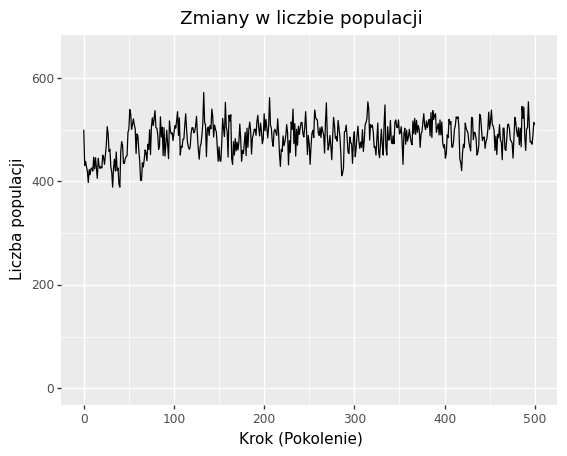

<ggplot: (107432193530)>

In [47]:
# Zmiany w liczbie populacji
def graph_population(environment: Environment):
        N0 = environment.history.iloc[0]["N"]
        myplot = ggplot(environment.history, aes(x = "step", y = "N")) + geom_line() + \
                geom_vline(xintercept=environment.history[environment.history["event"].notnull()]["step"], color="red") + \
                labs(title=f'Zmiany w liczbie populacji', x='Krok (Pokolenie)', y='Liczba populacji') + \
                        ylim(max(0, N0 - 1000), N0 + N0*0.3)
        return myplot
graph_population(environment)

Zgodnie ze wzorem na liczbę potomstwa, gdy nie ma zmian w optymalnym fenotypie, liczba populacji utrzymuje się na stałym poziomie - oscyluje wokół populacji początkowej, która w modelu jest jednoznaczna z pojemnością środowiska.

Jest to dynamika zbliżona do tej modelowanej wzorem logistycznego wzrostu populacji.

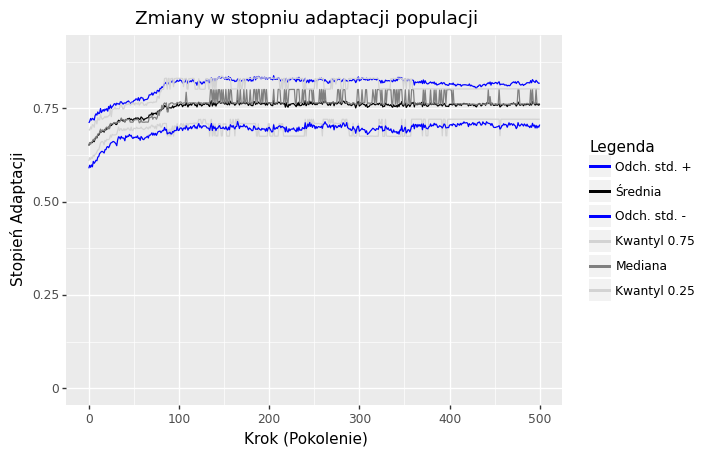

<ggplot: (107405791004)>

In [48]:
# Zmiany w stopniu adaptacji
def graph_adaptations(environment: Environment):
    avg_values = np.vectorize(lambda x: 0 if not x else np.average(x)) # x to jeden wektor wartości
    std_values = np.vectorize(lambda x: 0 if not x else np.std(x))
    med_values = np.vectorize(lambda x: 0 if not x else np.quantile(x, 0.5))
    upq_values = np.vectorize(lambda x: 0 if not x else np.quantile(x, 0.75))
    loq_values = np.vectorize(lambda x: 0 if not x else np.quantile(x, 0.25))

    environment.history["avg_adaptations"] = avg_values(environment.history["adaptations"])
    environment.history["std_adaptations1"] = avg_values(environment.history["adaptations"]) + \
                                                std_values(environment.history["adaptations"])
    environment.history["std_adaptations2"] = avg_values(environment.history["adaptations"]) - \
                                                std_values(environment.history["adaptations"])
    environment.history["med_adaptations"] = med_values(environment.history["adaptations"])
    environment.history["upq_adaptations"] = upq_values(environment.history["adaptations"])
    environment.history["loq_adaptations"] = loq_values(environment.history["adaptations"])

    # Topienie ramki dla ggplota
    super_df = pd.melt(environment.history, id_vars=["step"], \
                    value_vars=["avg_adaptations", \
                                    "std_adaptations1", \
                                    "std_adaptations2", \
                                    "med_adaptations", \
                                    "upq_adaptations", \
                                    "loq_adaptations"])

    myplot = ggplot(super_df) + \
        geom_line(aes(x = "step", y = "value", color = "variable")) + \
        geom_vline(xintercept=environment.history[environment.history["event"].notnull()]["step"], color="red") + \
        labs(title=f'Zmiany w stopniu adaptacji populacji', x='Krok (Pokolenie)', y='Stopień Adaptacji', color="Legenda") + \
        scale_color_manual(breaks=["std_adaptations1", "avg_adaptations", "std_adaptations2", \
                                    "upq_adaptations", "med_adaptations", "loq_adaptations"], \
                            values=["blue", "black", "blue", "lightgrey", "grey", "lightgrey"], \
                        labels=["Odch. std. +", "Średnia", "Odch. std. -", "Kwantyl 0.75", "Mediana", "Kwantyl 0.25"]) + \
                ylim(0.0, 0.9)
    return myplot

graph_adaptations(environment)

Śriednie przystosowanie rośnie i zbiega do pewnego maksimum, a wariancja adaptacji stopniowo maleje wraz z upływem czasu.

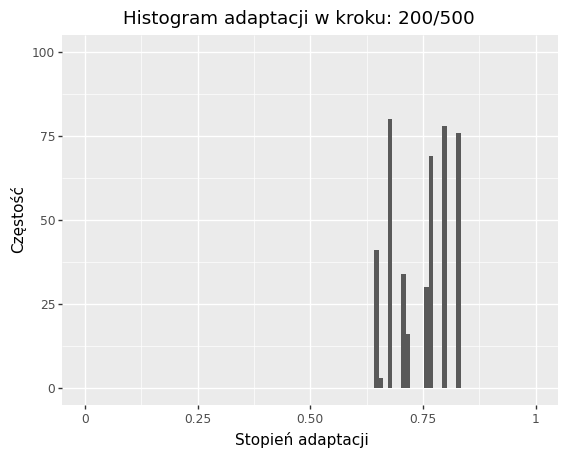

<ggplot: (107396013882)>

In [53]:
# Przykład histogramu dla danego kroku
check_step = 200
nbins = 100 # liczba koszyków
event = environment.history.iloc[check_step]["event"]
if not event:
    event = ""

myplot = ggplot() + geom_histogram(aes(x=environment.history.iloc[check_step]["adaptations"]), bins=nbins) + \
        labs(title=f'Histogram adaptacji w kroku: {check_step}/{n_steps} {event}', x='Stopień adaptacji', y='Częstość') + \
            xlim(0, 1) + ylim(0, 100)
    
myplot

Zmniejszenie się wariancji szczególnie dobrze ilustrują histogramy - początkowo przypominający rozkład normalny wykres zaczyna się skupiać wokół węższego zakresu wartości. Przy powtórzeniach symulacji zauważono, że osobniki często zaczynają się skupiać w odrębne grupy/klastry, o różnych wartościach przystosowania.

In [14]:
# Animacja dla histogramu
images = []

for step in range(n_steps):
    nbins = 100 # liczba koszyków
    event = environment.history.iloc[step]["event"]
    if not event:
        event = ""

    myplot = ggplot() + geom_histogram(aes(x=environment.history.iloc[step]["adaptations"]), bins=nbins) + \
            labs(title=f'Histogram adaptacji w kroku: {step}/{n_steps} {event}', x='Stopień adaptacji', y='Częstość') + \
                xlim(0, 1) + ylim(0, 100)
    
    filename = f"anim-hist\\f{step}.png" # \\ bo windows
    myplot.save(filename, dpi=100)
    
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave("anim-hist.gif", images, format='GIF', duration=1/24) # duration na jedną ramkę
print("Sukces")

Sukces


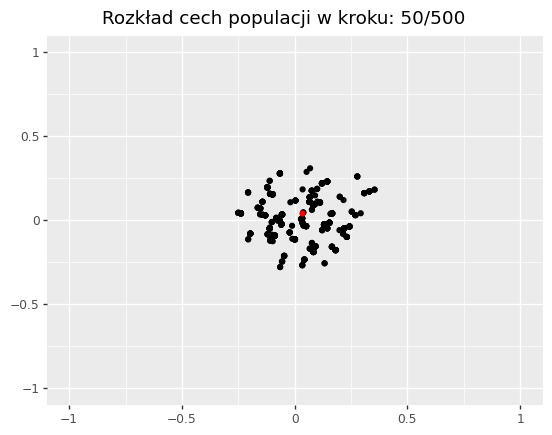

<ggplot: (107390124578)>

In [59]:
# Przykład rozkładu fenotypów (pca) dla jednego wybranego kroku

super_list = [] # pca na podstawie wszystkich danych
for step in range(n_steps + 1):
    super_list.append(environment.history.iloc[step]["optimum"])
    for phen in environment.history.iloc[step]["phenotypes"]:
        super_list.append(phen)

pca = PCA(n_components=2)
pca.fit(super_list)

check_step = 50 # wybrany krok
phens = environment.history.iloc[check_step]["phenotypes"]
opt = environment.history.iloc[check_step]["optimum"]

opt = pca.transform([opt])
event = environment.history.iloc[check_step]["event"]
if not event:
    event = ""

if len(phens) == 0:
    # jak populacja wymarła
    myplot = ggplot() + geom_point(aes(x = opt[:,0], y = opt[:,1]), color = "red") + \
            labs(title=f'Rozkład cech populacji w kroku: {check_step}/{n_steps} {event}') + \
                xlim(-1, 1) + ylim(-1, 1)
else:
    phens = pca.transform(phens)
    myplot = ggplot() + geom_point(aes(x = phens[:,0], y = phens[:,1])) + \
            geom_point(aes(x = opt[:,0], y = opt[:,1]), color = "red") + \
            labs(title=f'Rozkład cech populacji w kroku: {check_step}/{n_steps} {event}') + \
                xlim(-1, 1) + ylim(-1, 1)
myplot

Dokładne grupowanie się osobników zależy od symulacji, bo mutacje oraz dziedziczenie zachodzą losowo, ale przy stałym optymalnym fenotypie populacja zawsze kończyła z kilkoma odrębnymi grupami osobników o różnych wartościach przystosowania.

In [16]:
# Animacja fenotypów rozłożonych za pomocą pca
# 
super_list = [] # pca na podstawie wszystkich danych
images = []

for step in range(n_steps + 1):
    super_list.append(environment.history.iloc[step]["optimum"])
    for phen in environment.history.iloc[step]["phenotypes"]:
        super_list.append(phen)

pca = PCA(n_components=2)
pca.fit(super_list)

for step in range(n_steps):
    phens = environment.history.iloc[step]["phenotypes"]
    opt = environment.history.iloc[step]["optimum"]

    opt = pca.transform([opt])
    event = environment.history.iloc[step]["event"]
    if not event:
        event = ""

    if len(phens) == 0:
        # jak populacja wymarła
        myplot = ggplot() + geom_point(aes(x = opt[:,0], y = opt[:,1]), color = "red") + \
                labs(title=f'Rozkład cech populacji w kroku: {step}/{n_steps} {event}') + \
                    xlim(-1, 1) + ylim(-1, 1)
    else:
        phens = pca.transform(phens)
        myplot = ggplot() + geom_point(aes(x = phens[:,0], y = phens[:,1])) + \
                geom_point(aes(x = opt[:,0], y = opt[:,1]), color = "red") + \
                labs(title=f'Rozkład cech populacji w kroku: {step}/{n_steps} {event}') + \
                    xlim(-1, 1) + ylim(-1, 1)
        
    filename = f"anim-pca\\f{step}.png"
    myplot.save(filename, dpi=100)
    
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave("anim-pca.gif", images, format='GIF', duration=1/24) # duration na jedną ramkę
print("Sukces")

Sukces


In [17]:
# Różne parametry na przeżywalność
# Parametry
N0 = 500
n = 10
n_steps = 300
option = "climate_change" # proste zaburzenia do optimum

mus = [10 ** i for i in range(-10, 1)] # zestawy parametrów (od 1e-10 do 1, *=10)
sigmas = [i * 0.2 for i in range(0, 11)] # (od 0 do 2, +=0.2)

n_data = [[] for _ in range(len(sigmas))] # liczba populacji
a_data = [[] for _ in range(len(sigmas))] # średnie przystosowanie
s_data = [[] for _ in range(len(sigmas))] # odchylenie std. przystosowań

for i in range(len(mus)):
    for j in range(len(sigmas)):
        mu = mus[i]
        sigma = sigmas[j]
        environment = simulation(N0=N0, n=n, mu=mu, sigma=sigma, n_steps=n_steps, option=option)
        n_entry = environment.history.iloc[n_steps]["N"]
        a_entry = np.average(environment.history.iloc[n_steps]["adaptations"])
        s_entry = np.std(environment.history.iloc[n_steps]["adaptations"])
        n_data[j].append(n_entry)
        a_data[j].append(a_entry)
        s_data[j].append(s_entry)
print("Sukces")

Sukces


In [18]:
x, y = np.meshgrid(mus, sigmas) # Siatka parametrów

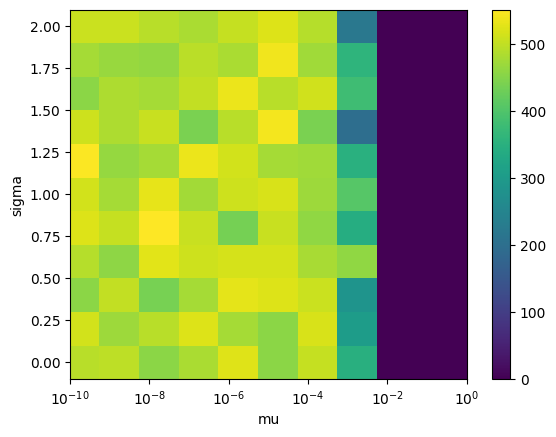

In [19]:
# liczba populacji
plt.pcolormesh(x, y, n_data)
plt.colorbar()
plt.ylabel("sigma")
plt.xscale('log')
plt.xlim(min(mus), max(mus))
plt.xlabel("mu")
plt.show()

Prawdopodobieństwo mutacji (mu) wyższe od $10^{-2}$ kończyło się zawsze wymarciem populacji, niezależnie od wartości efektu mutacji (sigmy).

Przy prawdopodobieństwie $10^{-3}$ liczba populacji znacznie malała, a przy niższych wartościach utrzymywała się na stałym poziomie, z dokładnością do epsilonu oscylacji populacji wokół pojemności środowiska (wartości na wykresie są brane tylko z ostatniego kroku symulacji).

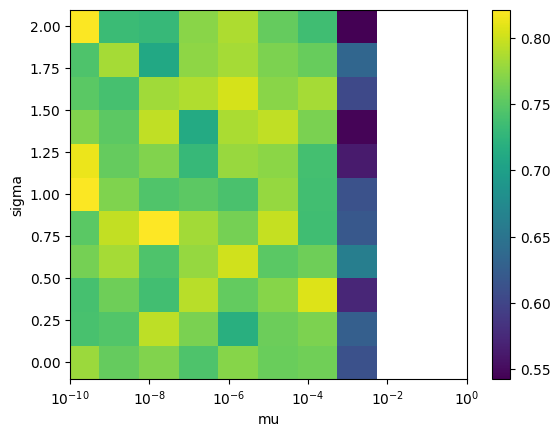

In [20]:
# średnie przystosowanie
plt.pcolormesh(x, y, a_data)
plt.colorbar()
plt.ylabel("sigma")
plt.xscale('log')
plt.xlim(min(mus), max(mus))
plt.xlabel("mu")
plt.show()

Analogiczna sytuacja do tej z liczbą populacji zachodzi dla średniej wartości adaptacji.

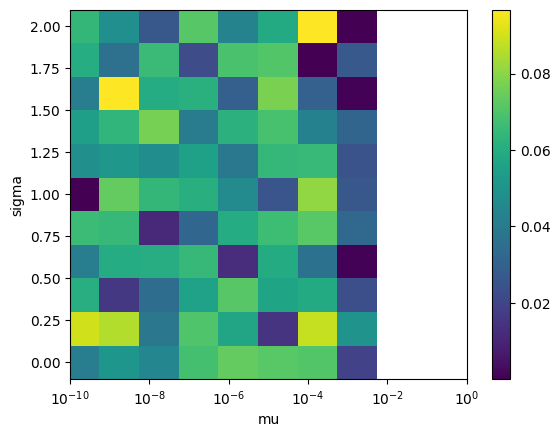

In [21]:
# odchylenie standardowe przystosowań
plt.pcolormesh(x, y, s_data)
plt.colorbar()
plt.ylabel("sigma")
plt.xscale('log')
plt.xlim(min(mus), max(mus))
plt.xlabel("mu")
plt.show()

Podobnie jest z odchyleniem standardowym, chociaż w tym wypadku różnice są mniej wyraźne.

In [37]:
# Wpływ katastrof na populację
N0 = 500
n = 10
mu = 1e-4
sigma = 0.25
n_steps = 500
option = "catastrophe"

environment = simulation(N0=N0, n=n, mu=mu, sigma=sigma, n_steps=n_steps, option=option)
print("===Sukces===")

===Sukces===


In [38]:
# Sprawdzenie jakie katastrofy zaszły, ile i kiedy
print(f"""
{environment.history["event"].value_counts()}{environment.history[environment.history["event"].notnull()]["step"]}""")


Pandemic     1
Meteorite    1
Godzilla     1
Name: event, dtype: int64127    127
173    173
233    233
Name: step, dtype: int64


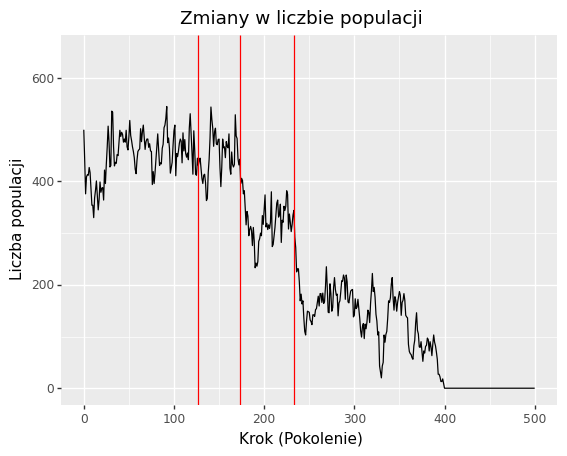

<ggplot: (107394786329)>

In [39]:
graph_population(environment)

Zajście katastrofy skutkowało najczęściej zmniejszeniem się liczby populacji. Nie zaobserwowano sytuacji, w której populacja by wróciła do początkowego poziomu po przejściu katastrofy, ale zdarzało się, że liczba populacji stabilizowała się na nowej wartości.

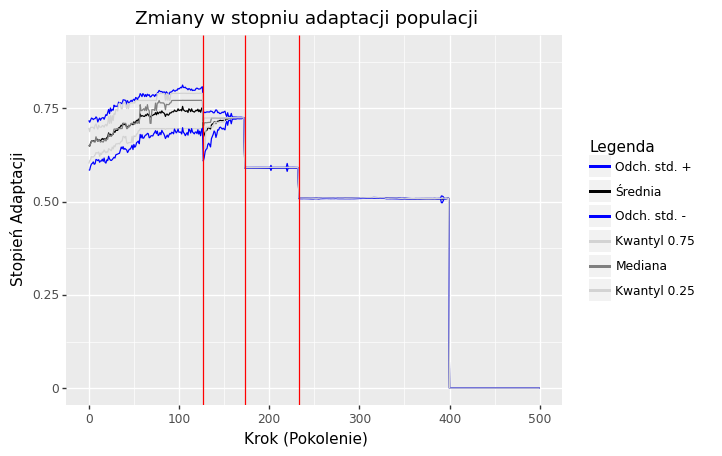

<ggplot: (107397252590)>

In [40]:
graph_adaptations(environment)

Po przejściu katastrofy, wariancja przystosowania zwykle się drastycznie zmniejszała. W niektórych przypadkach populacja prawie całkowicie się homogenizowała.

# Część Analityczna #

Wiele wyników otrzymanych z powyższych symulacji, można prześledzić do specyfiki implementacji modelu populacji, jednak niektóre obserwacje zgadzają się z tymi, które można zauważyć "w realu".

Model oddawał stopniowe zmniejszanie się wariancji różnorodności genetycznej populacji wraz z upływem czasu przy braku presji selekcyjnej. Jednak nieco niezrozumiałym zachowaniem było grupowanie się osobników w klastry o różnych przystosowaniach. Wykresy PCA późniejszych kroków również wskazują na to, że populacje grupowały się w rozdzielnych "klikach".

Inną obserwacją było to, że prawdopodobieństwo mutacji powyżej $10^{-2}$ kończyło się najczęściej wymarciem populacji (tutaj pracowano na populacji=500). Możliwym wytłumaczeniem takich wyników jest specyficzne dopasowanie parametrów oraz stałych wewnątrz modelu, np. zbyt duże mutacje w stosunku do zmian optimum mogło powodować, że genom potomka mógł znacznie łatwiej "przelecieć" poza sąsiedztwo z optimum. A im częściej takie mutacje, tym więcej osobników słabo dostosowanych do środowiska.

Przy stałych warunkach środowiskowych, liczba populacji sama się stabilizowała, co oddaje proces rozmnażania się organizmów, w świecie rzeczywistym, np. w sytuacji ciągłej presji _Daphnia_ zwiększają liczbę potomstwa kosztem wzrostu. Mimo to, ciekawą obserwacją było to, że w przypadku katastrof, pomimo wykorzystania wzoru na liczbę populacji, który starał się "odbić" liczbę populacji w przypadku jej zmniejszenia, populacje nie potrafiły powrócić do początkowego stanu, niezależnie od długości przeprowadzanych symulacji. Powyższe wykresy sugerują, że mogło mieć to związek ze specyficzną implementacją dziedziczenia genów, gdzie zamiast niezależnego rozdziału pojedynczych genów, model zakładał dziedziczenie całego zestawu genomu rodzica, co przy połączeniu z małym prawdopodobieństem mutacji ($10^{-4}$) mogło skutkować zmniejszeniem się puli genowej, co z kolei powodowało zmniejszanie się wariancji i możliwością "polepszenia" przystosowania, szczególnie po katastrofie.

# Część Ewaluacyjna #

Jest parę rzczy, które można by było zasugerować dla przyszłych implementacji tego typu modeli:

- Wykorzystanie wielowymiarowego rozkładu normalnego, N(mu, Sigma[macierz kowariancji]), dla zróżnicowania zachowań różnych genów, zamiast traktowania ich jednakowo

- Zaimplementowanie chromosomów oraz ich rekombinacji

- Zaimplementowanie modelu przestrzennego - rozmieszczenie osobników w przestrzeni. Pozwoliłoby to na zilustrowanie, np. spacjacji spowodowanej barierą geograficzną.
